<a href="https://colab.research.google.com/github/mkorlyakova/Segmentation/blob/master/Test_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт и инсталяция необходимого окружения

Грузим модули

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf


# Это своя метрика на Tensorflow DICE COEFF (https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2#:~:text=3.-,Dice%20Coefficient%20(F1%20Score),of%20union%20in%20section%202).)

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

Загружаем картинки для сегментации (имена одинаковые): 

- /images/изображение.png - это сам кадр 
- /labels/изображение.png - это разметка

Грузим репозиторий из git c проектом

In [5]:
!git clone -l -s https://github.com/mkorlyakova/Segmentation.git cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 19 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


Открываем архив (это зависит от архива)

тут по zip, поэтому грузим libarchive

In [6]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.6_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 163kB 10.4MB/s 


Раскрываем архив на виртуальной машине (картинок немного 17 шт.)

In [7]:
import libarchive.public

with open('/content/cloned-repo/images.zip', 'rb') as f:
    for entry in libarchive.public.memory_pour(f.read()):
        print(entry)

with open('/content/cloned-repo/labels.zip', 'rb') as f:
    for entry in libarchive.public.memory_pour(f.read()):
        print(entry)


ArchiveEntry<NAME=[images/00_000200.png] SIZE=(791603)>
ArchiveEntry<NAME=[images/00_002800.png] SIZE=(890605)>
ArchiveEntry<NAME=[images/00_000400.png] SIZE=(816531)>
ArchiveEntry<NAME=[images/00_003400.png] SIZE=(695524)>
ArchiveEntry<NAME=[images/00_002600.png] SIZE=(774166)>
ArchiveEntry<NAME=[images/00_002200.png] SIZE=(641760)>
ArchiveEntry<NAME=[images/00_002000.png] SIZE=(818966)>
ArchiveEntry<NAME=[images/00_001200.png] SIZE=(822001)>
ArchiveEntry<NAME=[images/00_001400.png] SIZE=(858981)>
ArchiveEntry<NAME=[images/00_001800.png] SIZE=(850589)>
ArchiveEntry<NAME=[images/00_001000.png] SIZE=(829576)>
ArchiveEntry<NAME=[images/00_003200.png] SIZE=(755342)>
ArchiveEntry<NAME=[images/00_002400.png] SIZE=(714888)>
ArchiveEntry<NAME=[images/00_003000.png] SIZE=(837876)>
ArchiveEntry<NAME=[images/00_001600.png] SIZE=(797385)>
ArchiveEntry<NAME=[images/00_000800.png] SIZE=(836923)>
ArchiveEntry<NAME=[images/00_000600.png] SIZE=(862976)>
ArchiveEntry<NAME=[labels/00_003400.png] SIZE=(1

Проверяем, что архивы раскрылись

In [8]:
!ls

cloned-repo  images  labels  sample_data


Прочитаем списки наших файлов (проверить идентичность, если имена одинаковые или собрать порядок чтения любым доступным способом)

In [9]:
import os, fnmatch
imag = os.listdir('/content/images/')
imag_label = os.listdir('/content/labels/')

In [10]:
imag,imag_label

(['00_000200.png',
  '00_001000.png',
  '00_000600.png',
  '00_002800.png',
  '00_002200.png',
  '00_001600.png',
  '00_003400.png',
  '00_003000.png',
  '00_001400.png',
  '00_003200.png',
  '00_000400.png',
  '00_002000.png',
  '00_001800.png',
  '00_002400.png',
  '00_001200.png',
  '00_000800.png',
  '00_002600.png'],
 ['00_000200.png',
  '00_001000.png',
  '00_000600.png',
  '00_002800.png',
  '00_002200.png',
  '00_001600.png',
  '00_003400.png',
  '00_003000.png',
  '00_001400.png',
  '00_003200.png',
  '00_000400.png',
  '00_002000.png',
  '00_001800.png',
  '00_002400.png',
  '00_001200.png',
  '00_000800.png',
  '00_002600.png'])

Задаю маршрут для чтения

In [11]:
PAHT_label = '/content/labels/'
PAHT_image = '/content/images/'
  

#Загружаем и уменьшаем картинки

можно обойтись исходным размером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [12]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))


Посмотрели на входные кадры

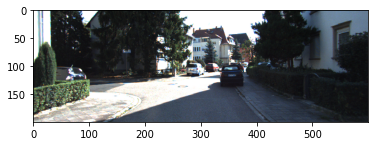

In [13]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

Посмотрим на цели

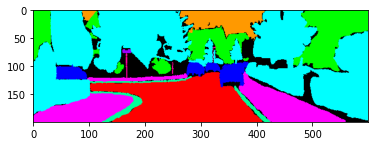

In [14]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

#Создаём выборку

Собираем входные примеры:

In [15]:
import cv2

Построим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принес разметчик

Color Coding:

Name	(r,g,b)	    7-Class mapping

Car	  ( 0, 0,255)	Object

Road	(255, 0, 0)	Road

Mark	(255,255, 0)	Road

Building	( 0,255, 0)	Building

Sidewalk	(255, 0,255)	Road

Tree/Bush	( 0,255,255)	Tree/Bush

Pole	(255, 0,153)	Sign/Pole

Sign	(153, 0,255)	Sign/Pole

Person	( 0,153,255)	Object

Wall	(153,255, 0)	Building

Sky	(255,153, 0)	Sky

Curb	( 0,255,153)	Road

Grass/Dirt	( 0,153,153)	Grass/Dirt

Void	( 0, 0, 0)	Void



Делаем конвертер в one-hot_encoding для выходных примеров

In [43]:
def Color2index(y):
  # y - входное rgb изображение для текущей легенды разметки
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
   
def index2color(y):
  # y - входное rgb изображение для текущей легенды разметки
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_col = np.zeros((y.shape[0],y.shape[1],3))
  #print(y.shape[-1])
  
  for i_color in range(y.shape[-1]):
    #print(arr_col[i_color])
    ind=np.where(y[:,:,i_color]==1)
    #print(ind[0].shape)
    for j in range(len(ind[0])):
      y_col[ind[0][j],ind[1][j],0] = arr_col[i_color][0] 
      y_col[ind[0][j],ind[1][j],1] = arr_col[i_color][1] 
      y_col[ind[0][j],ind[1][j],2] = arr_col[i_color][2] 
  
  return y_col

In [17]:

# Строим тестовый набор на 2 кадрах исходной выборки
xTest = []
yTest = []

# читаем изображения тестового набора (2 последних)
for i in range(2):
  img  = images[-1-i]
  seg = segments[-1-i]
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  x = image.img_to_array(img)
  xTest.append(x)
  yTest.append(y_cat) 

xTest = np.array(xTest)
yTest = np.array(yTest)

#Создаём  U-net



In [18]:
from tensorflow.keras.utils import plot_model

**Претренированная  Unet**

Грузим VGG16 и определяем список слоев для работы :

- смотрим на схему сжатия и не идем дальше 25х25  (нужно будет переделать на нормальные размеры типа 256х1024 - при чтении исходных кадров, тогда можно сжимать до 2х2 :))
- отделяю выход 13-го слоя, для работы в моей сети
- все слои замораживаю (все 18 слоев)
- от последнего рабочего слоя VGG16 (block4_conv3 (Conv2D)) ,буду надстраивать свою сеть
- при обучении используем размер тензоров (,200, 200, 3)(,200,200,14)
- после обучения перестраиваю сеть на размер (,200, 600, 3)(,200,600,14) . Это позволяет работать с любой картинкой нужного размера, а учить на меньших объектах, экономим память и время обработки, повышаем разнообразие в каждом пакекте (для медицинских фоток типа гистологий работает отлично, тут похуже).



In [ ]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

Строим рабочую модель

In [19]:
def unet_pre_train(num_classes = 13, input_shape= (200, 200, 3)):  
    # грузим   VGG16
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    # замораживаем все слои
    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    # фиксируем последний рабочий слой для своего потока  
    x = pre_trained_model.layers[13].output
    # фиксируем скипы для переноса из VGG16 (надо еще проверять)
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    #  фиксируем вход сети
    img_input = pre_trained_model.inputs

    # задаем список скипов 
    blocks = [block_4_out, block_3_out, block_2_out]
    #print(block_4_out)
    #print(block_3_out)
    #print(block_2_out)
    # UP 1

    
    for i in [0,1,2]:
      x = concatenate([x, blocks[i]]) # добавили перенос из понижаюшего плеча VGG16
      x = Conv2D(256, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(256, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      # UP i
      x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

    
    # последний слой сверток для классификации
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
    # собираем модель 
    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    # вернем модель
    return model

#Распознаём тестовую выборку

делаем предикт для примеров из тестов

Перестраиваю модель на размер 200х600

In [21]:
#pre_trained_model = VGG16(input_shape=xTest_big.shape[1:], include_top=False, weights="imagenet")

modelU_big = unet_pre_train(num_classes = 14, input_shape= (200, 600, 3))

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 200, 600, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 100, 300, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

Грузим веса из маленькой модели в большую (полносвязных слоев нет и размеры ядер не изменяются - веса одинаковые при любых размерах входов)


In [22]:
modelU_big.load_weights('modelU_weight.h5')

# Проверка для модели полного размера

делаем предсказание и визуализируем его

In [24]:
predu_big = modelU_big.predict(xTest)
print(predu_big.shape)

(2, 200, 600, 14)


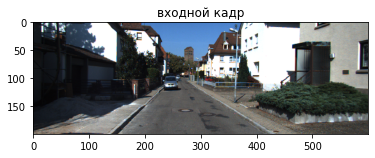

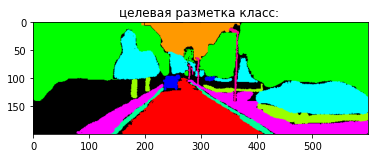

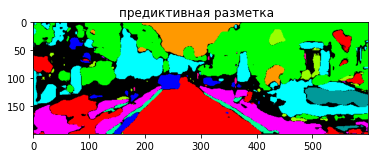

All samples DICE coeff =  0.70147216


In [46]:
n = 0 # номер примера для отображения (0 или 1))
class_ = 10 # индекс класса для отображения (от 0 до 13)


plt.imshow(xTest[n,:,:,:].astype(int))
plt.title('входной кадр')
plt.show()

img = index2color(np.round(yTest[n]))
plt.imshow(img.astype(int))
plt.title('целевая разметка класс: ')
plt.show()

img = index2color(np.round(predu_big[n]>0.5))
plt.imshow(img.astype(int))
plt.title('предиктивная разметка  ')
plt.show()

print('All samples DICE coeff = ',dice_coef(K.constant(yTest),K.constant(predu_big)).numpy())

Результат Распознавания новых картинок: DICE coeff =  0.70147216 по всем классам